# Takeaways
* Transforming a Series into a row vector - `a = a.reshape((len(a), -1))`
* Use `plt.text(x, y, 'text')` to add arbitrary text to matplotlib charts
* Plot multiple points with `data[[a, b]].plot(figsize=(20,12), style=['b', 'r']` etc
* `data['pred'].iloc[lags:` to fill in data that doesn't fill the full space another column does

# Recurrent Neural Networks
* A neural net architecture specifically designed for learning sequential data - like text and time series data.
* Again, using Keras
* Recurrent neural networks **maintain a memory** - each layer has some knowledge about the steps it has previously seen as the next step hits.
* When we talk about **fully unfolding an RNN**, we're talking about looking at the contribution of each timestep to the weights of the tensor in that layer.

In [230]:
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
from pprint import pprint
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score
plt.style.use('seaborn')
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

In [2]:
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
def set_seeds(seed=100):
    random.seed(seed)
    tf.random.set_random_seed(seed)
    np.random.seed(seed)

In [6]:
set_seeds()

In [7]:
a = np.arange(100)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [10]:
a = a.reshape((len(a), -1)) # 100 rows, 1 column
a.shape 

(100, 1)

# RNN Bootstrapping
* Use the Keras `TimeseriesGenerator` to transform time series data into raw material for training the RNN
* The idea here is to used lagged time series data to teach the network to predict the next value

In [21]:
lags = 3
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [22]:
pprint(list(g)[0]) # 5 periods of a 3-period window

(array([[[0],
        [1],
        [2]],

       [[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]],

       [[3],
        [4],
        [5]],

       [[4],
        [5],
        [6]]]),
 array([[3],
       [4],
       [5],
       [6],
       [7]]))


In [23]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu',
                  input_shape=(lags, 1)))
model.add(Dense(1, activation='linear')) # Linear output layer
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
%%time
model.fit_generator(g, epochs=1000, steps_per_epoch=5, verbose=False)

CPU times: user 25.3 s, sys: 3.35 s, total: 28.7 s
Wall time: 17.7 s


In [26]:
res = pd.DataFrame(model.history.history)

In [27]:
res.tail(3)

,loss,mae
997,1.1412,0.9720
998,1.3113,0.9942
999,0.3049,0.5194


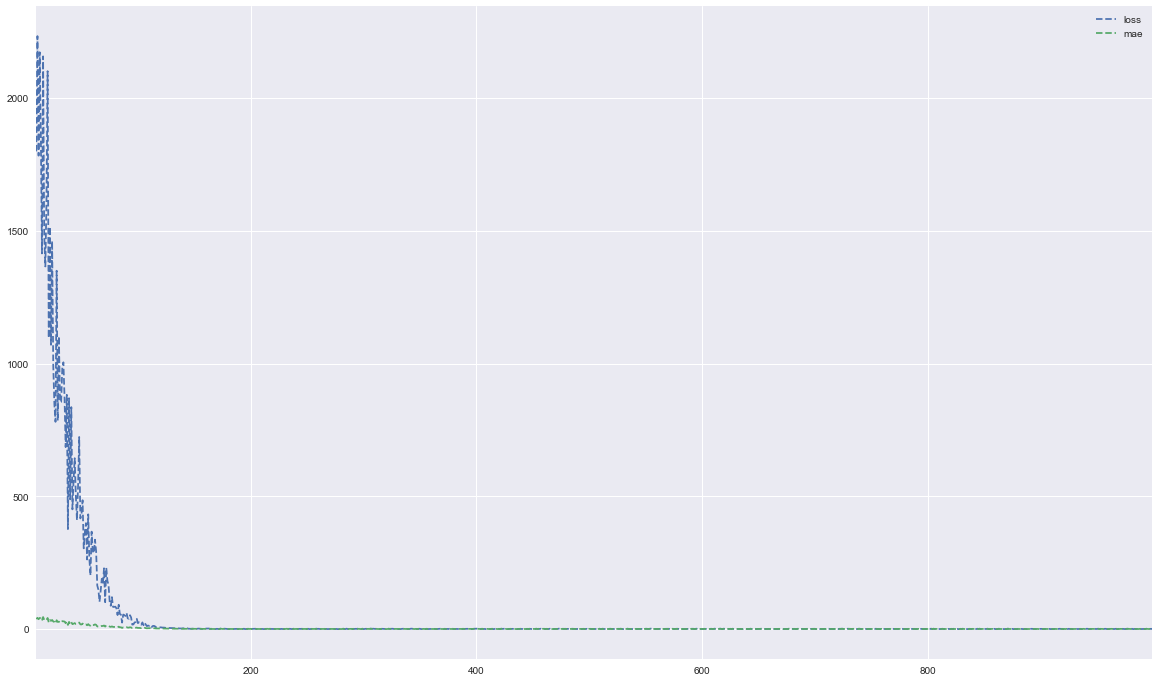

In [31]:
res.iloc[10:].plot(figsize=(20,12), style=['--', '--']) # Spiky erratic training

In [38]:
# RNN is now trained - generate prediction for "next value" from this
x = np.array([21,22,23]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0])) # Not great!

23

In [75]:
'''
Three dimensions: 1 x 3 x 1 - each value is contained in the 1 of each of the 3, which is contained in the 1
'''
x = np.array([87, 88, 89]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

91

In [78]:
x = np.array([187, 188, 189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False) 
int(round(y[0, 0]))

193

In [79]:
x = np.array([1187, 1188, 1189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

1220

# A More Sophisticated Example
* Next, we'll train an rnn on data that has a trigonmetric shape but is heavily noised by a quadratic term.

In [117]:
def transform(x):
    y = 0.05 * x ** 2 + 0.2 * x + np.sin(x) + 5
    y += np.random.standard_normal(len(x)) * 0.2 # Noise-ing
    return y

In [118]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 500)
a = transform(x)

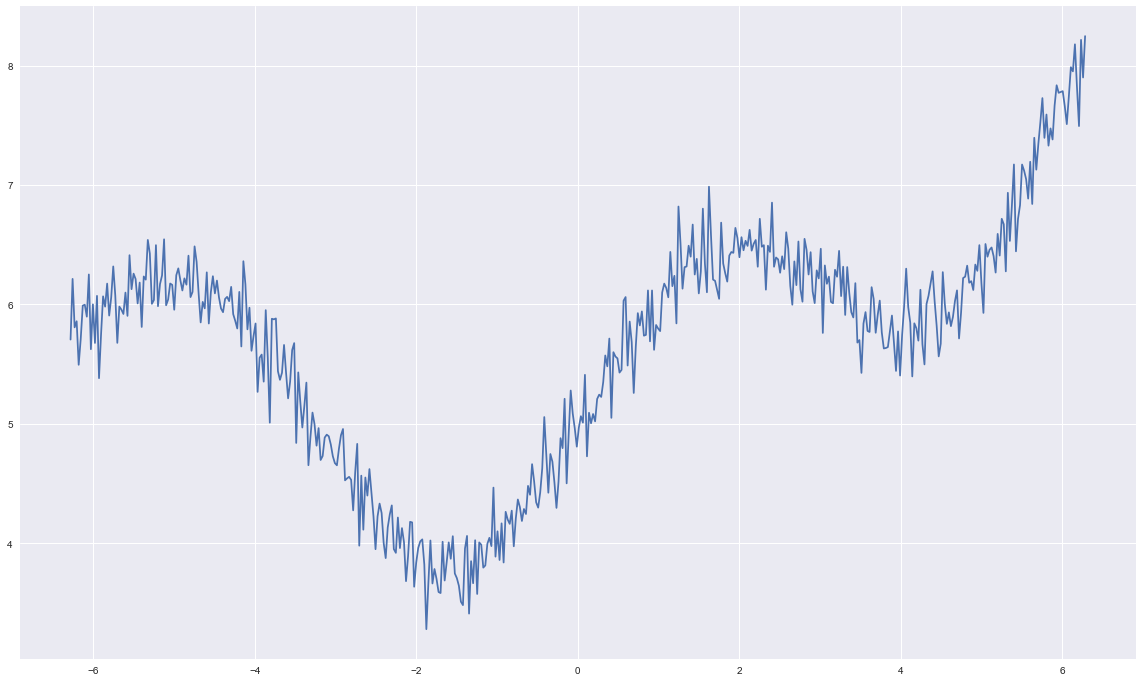

In [119]:
plt.figure(figsize=(20, 12))
plt.plot(x, a)

In [101]:
a.shape # We need to make this series into a matrix, albeit a 500 row 1 column one - so…

(500,)

In [102]:
# We do this
a = a.reshape((len(a), -1))
a.shape

(500, 1)

In [103]:
lags = 5
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [104]:
model = Sequential()
model.add(SimpleRNN(500, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 500)               251000    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


In [105]:
%%time
model.fit_generator(g, epochs=500, steps_per_epoch=10, verbose=False)

CPU times: user 54.5 s, sys: 10.3 s, total: 1min 4s
Wall time: 28.1 s


In [106]:
x2 = np.linspace(-6 * np.pi, 6 * np.pi, 1000) # Enlarged version to test on
d = transform(x2)

In [107]:
g_ = TimeseriesGenerator(d, d, length=lags, batch_size=len(d))

In [111]:
f = list(g_)[0][0].reshape((len(d) - lags, lags, 1))
f.shape # Need to understand why this reshape - 995 5s with 1 value
f[9]

array([[18.5859],
       [18.8536],
       [18.7672],
       [18.6472],
       [18.7081]])

In [112]:
y = model.predict(f, verbose=False)

# Prediction Accuracy
* With RNNs, predictions are 

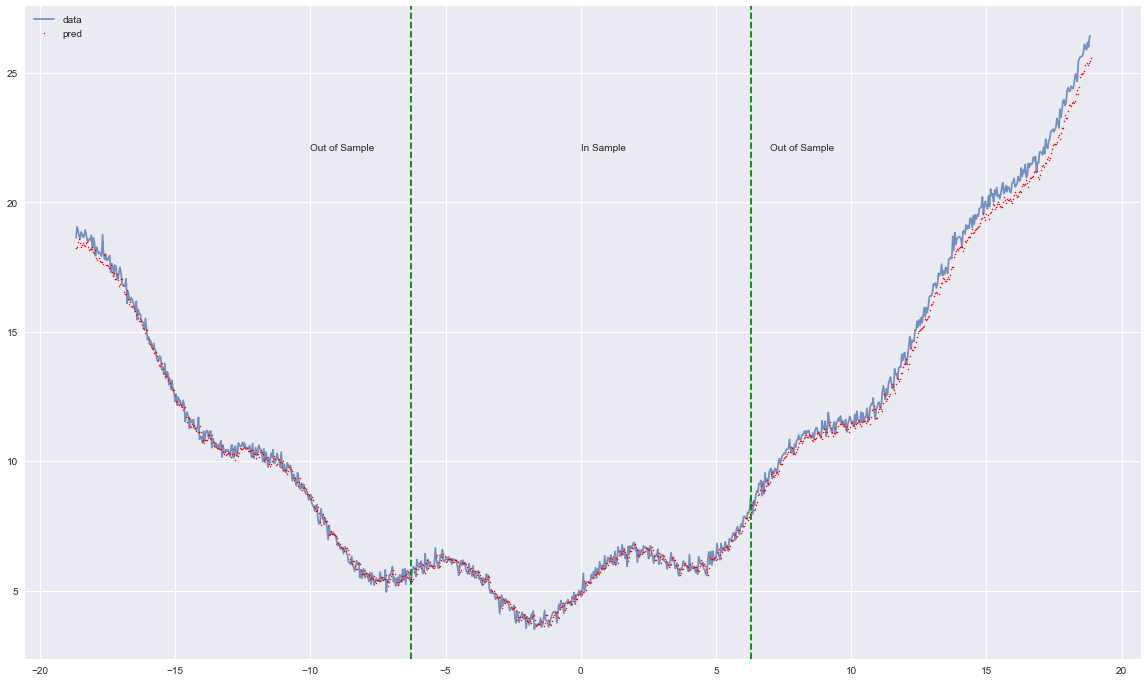

In [137]:
plt.figure(figsize=(20,12))
plt.plot(x2[lags:], d[lags:], label='data', alpha=0.75) # Raw data
plt.plot(x2[lags:], y, 'r.', label='pred', ms=3) # Prediction
plt.axvline(-2 * np.pi, c='g', ls='--') # Draw vertical lines to show in-sample
plt.axvline(2 * np.pi, c='g', ls='--') 
plt.text(-10, 22, 'Out of Sample')
plt.text(7, 22, 'Out of Sample')
plt.text(0, 22, 'In Sample')
plt.legend()

# Fitting RNN to Financial Time Series
* First, let's work on intraday EUR/USD quotes

In [138]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'

In [139]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [143]:
def generate_data():
    data = pd.DataFrame(raw['CLOSE'])
    data.columns = [symbol] # Rename the close column to the symbol name
    data = data.resample('30min', label='right').last().ffill() # Fill forward on the resample
    return data

In [144]:
data = generate_data()

In [149]:
data = (data - data.mean())/data.std() # Gaussian normalization
data.shape #(4415, 1)
data.tail()

,EUR_USD
Date,
2019-12-31 21:30:00,2.2034
2019-12-31 22:00:00,2.1406
2019-12-31 22:30:00,2.1877
2019-12-31 23:00:00,2.1877
2019-12-31 23:30:00,2.1877


In [156]:
p = data[symbol].values # Numpy array
p.shape
p[-5:] 

array([2.2034, 2.1406, 2.1877, 2.1877, 2.1877])

In [160]:
p = p.reshape(len(p), -1) # Convert to p X 1 row matrix
p[2][0]

-2.821079523437356

# Training
* Now train the RNN with a TimeSeriesGenerator object - either a simpleRNN or an LSTM

In [161]:
lags = 5
g = TimeseriesGenerator(p, p, length=lags, batch_size=5)

In [166]:
def create_rnn_model(hu=100, lags=lags, layer='SimpleRNN', features=1, algorithm='estimation'):
    
    model = Sequential()
    # Recurrent layer type
    if layer is 'SimpleRNN':
        model.add(SimpleRNN(hu, activation='relu', input_shape=(lags, features)))
    else:
        model.add(LSTM(hu, activation='relu', input_shape=(lags, features)))
    
    # Optimization algorithm
    if algorithm == 'estimation': # Regression
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    else:
        model.add(Dense(1, activation='sigmoid')) # Labels
        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model
    

In [167]:
model = create_rnn_model()

In [168]:
%%time
model.fit_generator(g, epochs=500, steps_per_epoch=10, verbose=False)

CPU times: user 24.3 s, sys: 4.12 s, total: 28.5 s
Wall time: 14.8 s


In [169]:
y = model.predict(g, verbose=False) # In sample

In [170]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten() # Paste y in after lags

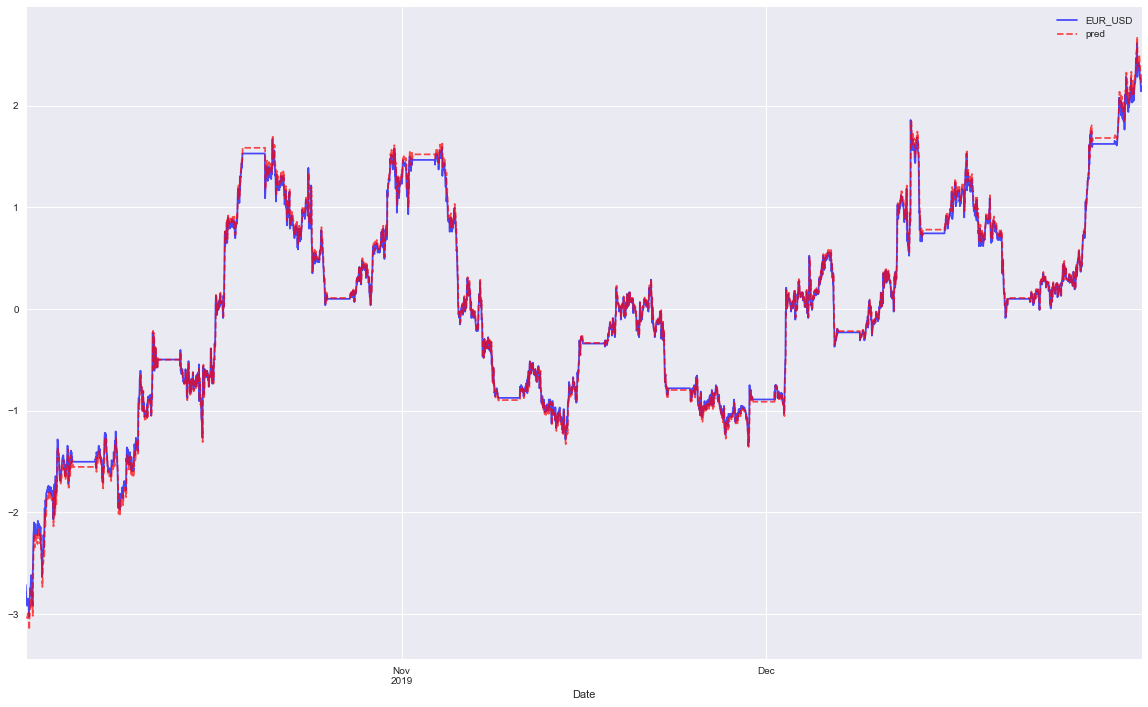

In [171]:
data[[symbol, 'pred']].plot(figsize=(20, 12), style=['b', 'r--'], alpha=0.7)

* Looks good from the full series - but let's zoom in

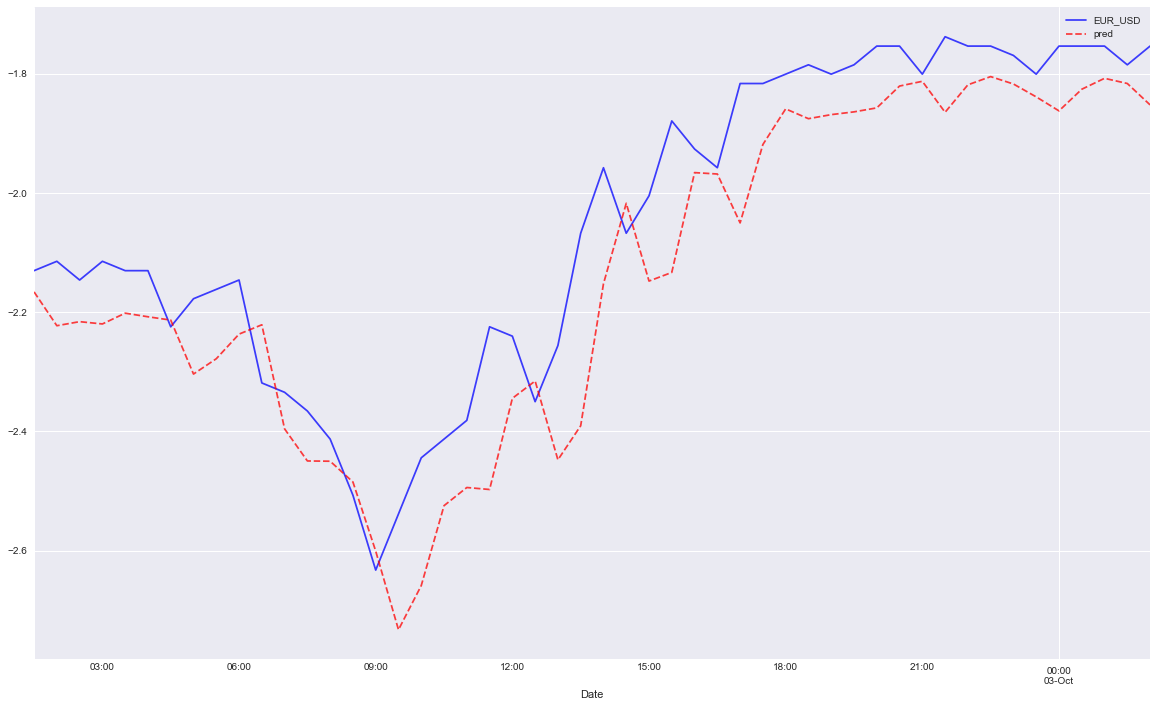

In [172]:
data[[symbol, 'pred']].iloc[50:100].plot(figsize=(20,12), style=['b', 'r--'], alpha=0.75)

# Come On!
* It is just predicting the next value to be the current one slightly shifted or repeated

# Fitting RNN to Financial Return Series

In [173]:
data = generate_data()

In [174]:
data['r'] = np.log(data / data.shift(1))

In [175]:
data.dropna(inplace=True)

In [176]:
data = (data - data.mean()) / data.std()

In [178]:
r = data['r'].values
type(r)

numpy.ndarray

In [181]:
r = r.reshape(len(r), -1) # r x 1 matrix
r.shape

(4414, 1)

In [182]:
g = TimeseriesGenerator(r, r, length=lags, batch_size=5)

In [183]:
model = create_rnn_model()

In [184]:
%%time
model.fit_generator(g, epochs=500, steps_per_epoch=10, verbose=False)

CPU times: user 24.2 s, sys: 4.39 s, total: 28.6 s
Wall time: 14.7 s


In [185]:
# Prediction Time!
y = model.predict(g, verbose=False)

In [186]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()
data.dropna(inplace=True)

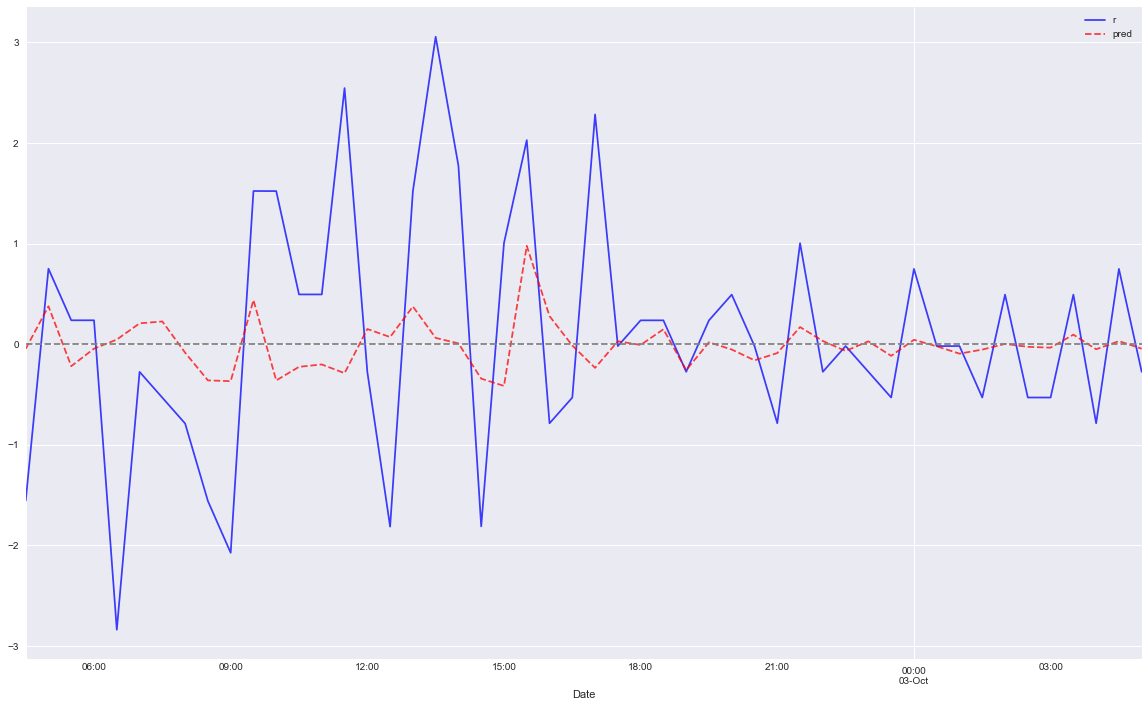

In [187]:
data[['r', 'pred']].iloc[50:100].plot(
figsize=(20,12),
style=['b', 'r--'],
alpha=0.75)
plt.axhline(0, c='grey', ls='--')

* So the prediction is pretty melodramatic, but it gets the directionality right a decent amount of the time - **especially the big moves**

In [190]:
accuracy_score(np.sign(data['r']), np.sign(data['pred'])) # Nice

0.6929008845543208

In [191]:
# Now Train-Test-Split
split = int(len(r) * 0.8)

In [192]:
train = r[:split]
test = r[split:]

In [193]:
g = TimeseriesGenerator(train, train, length=lags, batch_size=5)

In [196]:
set_seeds()
model = create_rnn_model(hu=100)

In [197]:
%%time
model.fit_generator(g, epochs=100, steps_per_epoch=10, verbose=False)

CPU times: user 5.46 s, sys: 912 ms, total: 6.37 s
Wall time: 3.65 s


In [198]:
g_ = TimeseriesGenerator(test, test, length=lags, batch_size=5)

In [199]:
y = model.predict(g_)

In [201]:
accuracy_score(np.sign(test[lags:]), np.sign(y)) # Not horrible

0.6662870159453302

# Fitting RNN to Additional Financial Features

In [202]:
data = generate_data()

In [203]:
data['r'] = np.log(data/data.shift(1))

In [206]:
window = 20
data['mom'] = data['r'].rolling(window).mean() # Momentum
data['vol'] = data['r'].rolling(window).std() # Volatility
data.dropna(inplace=True)

In [207]:
split = int(len(data) * 0.8)

In [208]:
train = data.iloc[:split].copy()
mu, std = train.mean(), train.std()

In [209]:
train = (train - mu)/std

In [210]:
test = data.iloc[split:].copy()
test = (test - mu)/std

In [211]:
g = TimeseriesGenerator(train.values, train['r'].values, length=lags, batch_size=5)

In [212]:
set_seeds()
model = create_rnn_model(hu=100, features=len(data.columns), layer='SimpleRNN')

In [213]:
%%time
model.fit_generator(g, epochs=100, steps_per_epoch=10, verbose=False)

CPU times: user 5.29 s, sys: 921 ms, total: 6.21 s
Wall time: 3.44 s


In [214]:
g_ = TimeseriesGenerator(test.values, test['r'].values, length=lags, batch_size=5)

In [217]:
y = model.predict(g_).flatten()

In [219]:
accuracy_score(np.sign(test['r'].iloc[lags:]), np.sign(y)) # No improvement, actually slightly worse!

0.6636050516647531

# Fitting RNN To A Classification Setting
* We can fit to directional instrument price labels instead - up or down?

In [220]:
set_seeds()
model = create_rnn_model(hu=50,
                        features=len(data.columns),
                        layer='LSTM',
                        algorithm='classification')

In [222]:
train_y = np.where(train['r'] > 0, 1, 0)
train_y.shape

(3500,)

In [223]:
g = TimeseriesGenerator(train.values, train_y, length=lags, batch_size=5)

In [224]:
%%time
model.fit_generator(g, epochs=5, steps_per_epoch=10, verbose=False)

CPU times: user 1.32 s, sys: 224 ms, total: 1.54 s
Wall time: 1.46 s


In [226]:
test_y = np.where(test['r'] > 0, 1, 0)

In [227]:
g_ = TimeseriesGenerator(test.values, test_y, length=lags, batch_size=5)

In [228]:
y = model.predict_classes(g_, batch_size=None).flatten() # Predict classes just on lagged Timeseries from test, one arg

In [229]:
accuracy_score(test_y[lags:], y) # Pretty damn good on relative direction!

0.687715269804822

# Deep RNNs - A RNN with multiple hidden layers

In [240]:
def create_deep_rnn_model(hl=2, hu=100, layer='SimpleRNN',
                         optimizer='rmsprop', features=1,
                         dropout=False, rate=0.3, seed=100):
    if hl <= 2: hl=2 # Force hiddenness
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
    model = Sequential()
    model.add(layer(hu, input_shape=(lags, features), return_sequences=True))
    
    if dropout:
        model.add(Dropout(rate, seed=seed))
        
    for _ in range(2, hl):
        model.add(layer(hu, return_sequences=True))
        if dropout:
            model.add(Dropout(rate, seed=seed))
    model.add(layer(hu))
    model.add(Dense(1, activation='sigmoid')) # Classificaton output layer
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [241]:
set_seeds()
model = create_deep_rnn_model(
hl=2, hu=100, layer='SimpleRNN',
features=len(data.columns),
dropout=True, rate=0.3)

In [242]:
%%time 
model.fit_generator(g, epochs=250, steps_per_epoch=10, verbose=False)

CPU times: user 19.3 s, sys: 3.28 s, total: 22.6 s
Wall time: 11.5 s


In [243]:
y = model.predict_classes(g_, batch_size=None).flatten()

In [244]:
accuracy_score(test_y[lags:], y)

0.6831228473019518